# Neural Networks with the Kepler Objects of Interest Data
Using KOI cumulative dataset, create a Neural Network to predict the presence of exoplanets around nearby stars

***Matt Paterson, hello@hireMattPaterson.com***<br>
**Data Science Fellow, General Assembly, 2020**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Import the dataset from the data directory. We'll establish pathway variables here so that if you use this notebook in your own project you can adjust these datapath variables without having to change your whole notebook.

In [2]:
path_to_home = '../'
datapath = path_to_home + 'data/'

In [3]:
df = pd.read_csv(datapath + 'dirty_kepler.csv')
df.head()

,kepid,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,12168280,2,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
1,11923074,0,0,0,0,1,1.756471,0.000015,-0.000015,132.02757,...,-157.0,4.561,0.033,-0.176,0.833,0.227,-0.071,296.14072,50.279949,14.723
2,11867733,0,0,1,0,0,384.356448,0.003680,-0.003680,298.90354,...,-193.0,4.445,0.067,-0.202,0.994,0.291,-0.125,293.77362,50.124470,14.391
3,10585887,0,1,0,0,0,378.654840,0.022800,-0.022800,288.25840,...,-209.0,4.463,0.070,-0.210,0.970,0.306,-0.123,285.24338,47.812592,14.872
4,10532751,0,1,0,0,0,367.761848,0.006750,-0.006750,194.76970,...,-295.0,2.897,0.045,-0.014,9.888,0.257,-2.058,290.87155,47.753368,10.736


Before we really deep dive in to the dataset, let's establish a null baseline and a baseline using a Neural Network.  The NN will not be very good here, but we should at least see our machine start learning the data. We will create a more useful model later once we have our footing.

In [4]:
df.koi_disposition.value_counts(normalize=True)

0    0.481930
1    0.261322
2    0.256747
Name: koi_disposition, dtype: float64

In [5]:
df.shape

(8744, 42)

In this dataset, we see that Cal-Tech and NASA have already decided that 1 in four KOI are indeed exoplanets and 2 in 4 are not, leaving the remaining 1 in 4 as simply candidates at this point. We have already moved the unknown candidates in to another csv, called 'kepler_candidates.csv' and placed it in the same datapath as this 'dirty' dataset so we can delete all of the rows here that have a koi_disoposition of '2'.

It should be noted that there is an anecdotal possibility that the KOI that have been dismissed at this point are the ones that are the easiest to dismiss. This then does not make it more likely that the remaining 2200 or so observations have a similar 65%-35% split.

In [6]:
df = df[df.koi_disposition!=2]
df.koi_disposition.value_counts(normalize=True)

0    0.648407
1    0.351593
Name: koi_disposition, dtype: float64

## Baseline data imbalance

In [7]:
baseline = df.koi_disposition.value_counts(normalize=True)[1]
baseline

0.35159255270041545

Our null average, or the imbalance in our data, has 35% of classified KOI as exoplanets, and 65% are not exoplanets

## train_test_split
Split up our dirty KOI dataframe into a training set and a validation set, using the koi_disposition column as the target column, then scale the data to fit better into classification models.

Later, after we re-tool the data and before we better tune a model, we'll need to replicate this step completely. As such, we'll turn this whole process in to a function.

In [8]:
def kepler_data_split(dataframe):
    '''
    Employs the train_test_split function and the StandardScalar() as well
    
    '''
    X = dataframe.drop(columns='koi_disposition')
    y = dataframe['koi_disposition']

    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = .2, 
                                                      random_state = 42, 
                                                      stratify=y)

    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_val_sc = sc.transform(X_val)
    
    return X_train, X_train_sc, X_val, X_val_sc, y_train, y_val

In [9]:
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = kepler_data_split(df)

## Create the metrics display function

In [10]:
# base code From Matt Brems, Tim Book, and Justin Pounders
# improved by Matt Paterson
def display_metrics(model_name, metric):
    train_loss = model_name.history[metric]
    test_loss = model_name.history['val_' + metric]

    plt.figure(figsize=(12, 8))
    plt.plot(train_loss, label='Training ' + metric, color='navy')
    plt.plot(test_loss, label='Validation val_' + metric, color='fuchsia')
    plt.legend();

## Baseline Neural Network

In [11]:
bsn = Sequential()
bsn.add(Dense(41, input_dim=X_train.shape[1], activation='relu'))
bsn.add(Dense(16, activation='relu'))
bsn.add(Dense(1, activation='sigmoid'))

bsn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc']) # loss = 'bce'

history_bsn = bsn.fit(
    X_train_sc,
    y_train,
    validation_data=(X_val_sc, y_val),
    epochs=100,
    batch_size=None,
    verbose=2
)

Epoch 1/100
163/163 - 1s - loss: 0.3604 - acc: 0.8629 - val_loss: 0.1344 - val_acc: 0.9692
Epoch 2/100
163/163 - 1s - loss: 0.1184 - acc: 0.9679 - val_loss: 0.0668 - val_acc: 0.9823
Epoch 3/100
163/163 - 0s - loss: 0.0802 - acc: 0.9761 - val_loss: 0.0534 - val_acc: 0.9831
Epoch 4/100
163/163 - 0s - loss: 0.0637 - acc: 0.9804 - val_loss: 0.0522 - val_acc: 0.9838
Epoch 5/100
163/163 - 0s - loss: 0.0546 - acc: 0.9846 - val_loss: 0.0479 - val_acc: 0.9854
Epoch 6/100
163/163 - 0s - loss: 0.0457 - acc: 0.9873 - val_loss: 0.0437 - val_acc: 0.9846
Epoch 7/100
163/163 - 0s - loss: 0.0385 - acc: 0.9877 - val_loss: 0.0410 - val_acc: 0.9846
Epoch 8/100
163/163 - 0s - loss: 0.0338 - acc: 0.9896 - val_loss: 0.0350 - val_acc: 0.9869
Epoch 9/100
163/163 - 0s - loss: 0.0293 - acc: 0.9913 - val_loss: 0.0343 - val_acc: 0.9869
Epoch 10/100
163/163 - 0s - loss: 0.0254 - acc: 0.9935 - val_loss: 0.0321 - val_acc: 0.9877
Epoch 11/100
163/163 - 0s - loss: 0.0230 - acc: 0.9935 - val_loss: 0.0291 - val_acc: 0.98

Epoch 89/100
163/163 - 0s - loss: 1.9236e-04 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9954
Epoch 90/100
163/163 - 0s - loss: 1.6955e-04 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9954
Epoch 91/100
163/163 - 1s - loss: 1.6532e-04 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9946
Epoch 92/100
163/163 - 1s - loss: 1.4193e-04 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 0.9962
Epoch 93/100
163/163 - 0s - loss: 1.3858e-04 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 0.9962
Epoch 94/100
163/163 - 0s - loss: 1.5561e-04 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9962
Epoch 95/100
163/163 - 0s - loss: 1.2158e-04 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9962
Epoch 96/100
163/163 - 1s - loss: 1.2569e-04 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 0.9954
Epoch 97/100
163/163 - 0s - loss: 1.3584e-04 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9962
Epoch 98/100
163/163 - 0s - loss: 1.0893e-04 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9962
Epoch 99/100
163/163 - 0s - loss: 1.1752

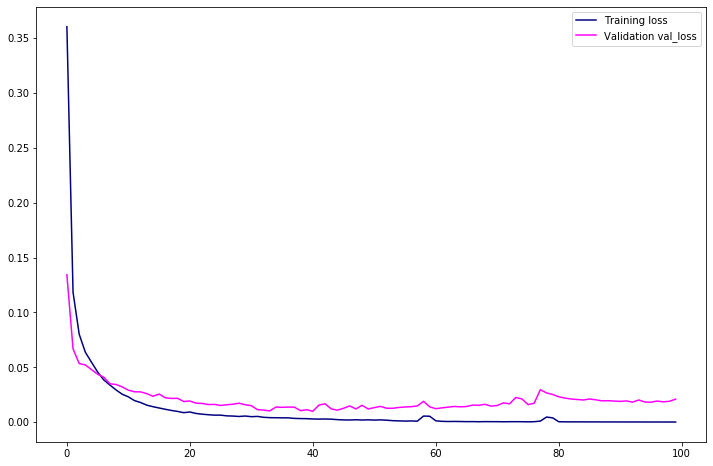

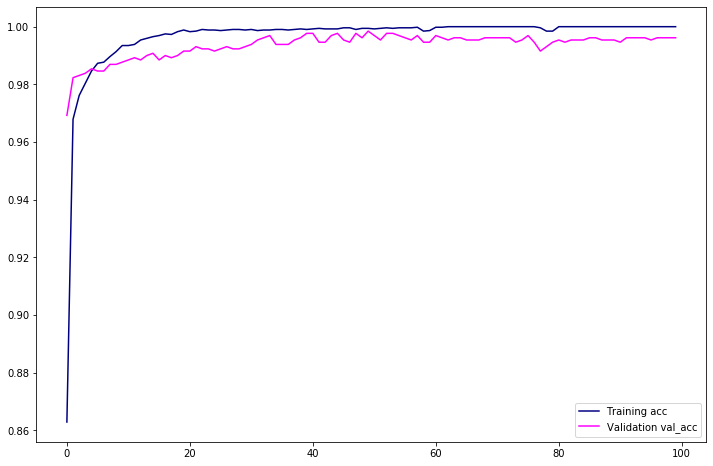

In [12]:
display_metrics(history_bsn, 'loss')
display_metrics(history_bsn, 'acc')

In [13]:
model_fnn_top_score = sorted(history_bsn.history['val_acc'], reverse=True)[0]
print(f'This model has a maximum accuracy score of {model_fnn_top_score}')

model_fnn_best_loss = sorted(history_bsn.history['val_loss'], reverse=False)[0]
print(f'This model has a minimum loss score of {model_fnn_best_loss}')

This model has a maximum accuracy score of 0.9984615445137024
This model has a minimum loss score of 0.009879921562969685


That's one helluva baseline. I suppose I can make some predictions now on the raw unknown data.

In [24]:
# the candidates csv contains prior predictions, so we must delete them
unk = pd.read_csv(datapath + 'kepler_candidates.csv')
unk = unk.drop(columns='exoplanet')
unk.head()

,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,12168280,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,0.01510,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
1,9592621,0,0,0,0,191.037280,0.013200,-0.013200,153.91070,0.06480,...,-180.0,4.497,0.055,-0.165,0.901,0.213,-0.091,293.68390,46.265541,16.652
2,9159288,0,0,0,0,66.673050,0.012400,-0.012400,161.59000,0.17600,...,-256.0,4.369,0.072,-0.217,1.190,0.404,-0.135,293.68979,45.549332,14.634
3,9011955,0,0,0,0,367.089600,0.022800,-0.022800,178.67440,0.04220,...,-260.0,4.429,0.058,-0.232,1.100,0.384,-0.128,287.86737,45.321289,15.267
4,8673511,0,0,0,0,0.757261,0.000004,-0.000004,131.62154,0.00472,...,-171.0,4.479,0.062,-0.200,0.953,0.279,-0.093,284.29565,44.895859,14.024


In [25]:
sc = StandardScaler()
unk_sc = sc.fit_transform(unk)
unk_sc.shape
unk.columns

Index(['kepid', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

In [26]:
unk['exoplanet'] = bsn.predict_classes(unk_sc)
unk.head()

,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,exoplanet
0,12168280,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,0.01510,...,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505,0
1,9592621,0,0,0,0,191.037280,0.013200,-0.013200,153.91070,0.06480,...,4.497,0.055,-0.165,0.901,0.213,-0.091,293.68390,46.265541,16.652,0
2,9159288,0,0,0,0,66.673050,0.012400,-0.012400,161.59000,0.17600,...,4.369,0.072,-0.217,1.190,0.404,-0.135,293.68979,45.549332,14.634,0
3,9011955,0,0,0,0,367.089600,0.022800,-0.022800,178.67440,0.04220,...,4.429,0.058,-0.232,1.100,0.384,-0.128,287.86737,45.321289,15.267,0
4,8673511,0,0,0,0,0.757261,0.000004,-0.000004,131.62154,0.00472,...,4.479,0.062,-0.200,0.953,0.279,-0.093,284.29565,44.895859,14.024,0


In [27]:
unk.exoplanet.value_counts()

0    2211
1      34
Name: exoplanet, dtype: int64

We have just predicted that 34 of the remaining candidate koi's are indeed exoplanets.

## Premature Conclusion


This notebook was meant to have been a baseline, establishing a starting point from which I would engineer features, or remove features, before really getting a good grasp on the domain knowledge.  Instead, I have a model that--if all results are correct--is pretty tough to improve upon.

Of course, I don't trust that my bounding into this dataset is suddenly producing more confident predictions than CalTech and NASA have, so I'd love some feedback from anyone that has worked with exoplanet data, or has dipped their toes in to neural networks and gotten some misleading results early on.

I should also note that the RandomForestClassifier baseline had roughly the same accuracy score yet classified 1390 exoplanets from the same csv of unknown candidates.